In [8]:
import numpy
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

import glob
import os
import csv
from pprint import pprint
from pathlib import Path
import xml.etree.ElementTree as ET

from IPython.display import Image
from IPython.core.display import HTML

# Remove numpy warnings
import warnings
warnings.filterwarnings('ignore')

### mAP

Bounding boxes are a crude approximation of many objects. 
Ground truth boxes :  Box that denote the true position of an object (x,y,width,height).

### IoU (Intersection over Union)
It is the measure of the ratio between the intersection and the union of the predicted box and the ground truth boxes.[1]


In [9]:
Image(url= "https://tarangshah.com/blog/images/map-7.png", width=300, height=300)

### Precision & Recall

True Positive
False Positive
True Negative
False Negative

Total Number of Objects

Precision : 
Recall :

In [10]:
def read_annotation(annotation_path:str):
    status = True
    
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    all_results = []
    for boxes in root.iter('object'):
        single_result = {}

        filename = root.find('filename').text
        class_name = boxes.find('name').text
        
        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = (xmin, ymin, xmax, ymax)
        single_result['label'] = class_name
        single_result['bbox'] = list_with_single_boxes
        
        all_results.append(single_result)

    result = {}
    result["status"] = status 
    result["results"] = all_results 
    
    return result

result = read_annotation("/home/jayasimha/Pictures/door_2.xml")
pprint(result)

{'results': [{'bbox': (80, 40, 144, 185), 'label': 'door'},
             {'bbox': (34, 6, 67, 55), 'label': 'lamp'}],
 'status': True}


In [11]:
class ObjDetector():
    def __init__(self):
        self.graph_def = None
        self.out = None
        self.img = None
        self.labels = {}
        
        self.rows = 0
        self.cols = 0
    
    def initialize_model(self,pb_path:str):
        with tf.gfile.FastGFile(pb_path, 'rb') as f:
            self.graph_def = tf.GraphDef()
            self.graph_def.ParseFromString(f.read())
            
    def set_labels(self,path:str):
        with open(path, 'r') as csvFile:
            reader = csv.reader(csvFile)
            for i,row in enumerate(reader):
                self.labels[i+1] = row[-1]
        csvFile.close()
    
    def run_detection(self,img_path:str):
        with tf.Session() as sess:
            # Restore session
            sess.graph.as_default()
            tf.import_graph_def(self.graph_def, name='')

            # Read and preprocess an image.
            self.img = cv2.imread(img_path)
            self.img = cv2.resize(self.img,(480,640))
    
            self.rows = self.img.shape[0]
            self.cols = self.img.shape[1]
            inp = cv2.resize(self.img, (300, 300))
            inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

            # Run the model
            self.out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                            sess.graph.get_tensor_by_name('detection_scores:0'),
                            sess.graph.get_tensor_by_name('detection_boxes:0'),
                            sess.graph.get_tensor_by_name('detection_classes:0')],
                           feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
        
        return self
                
    
    def get_result(self):
        status = True
        
        all_results = []
        # Visualize detected bounding boxes.
        num_detections = int(self.out[0][0])
        for i in range(num_detections):
            single_result = {}

            classId = int(self.out[3][0][i])
            score = float(self.out[1][0][i])
            bbox = [float(v) for v in self.out[2][0][i]]
            if score > 0.3:
                x = int(bbox[1] * self.cols)
                y = int(bbox[0] * self.rows)
                right = int(bbox[3] * self.cols)
                bottom = int(bbox[2] * self.rows)
                
                #cv2.rectangle(img, (int(x), int(y)), (int(right), int(bottom)),(125, 255, 51), thickness=2)
                
                single_result['label'] = self.labels[classId]
                single_result['bbox'] = (x,y,x+right,y+bottom)
                
                all_results.append(single_result)
                
        result = {}
        result["status"] = status 
        result["results"] = all_results
    
        return img , result

In [12]:
def get_bbox_for_label(json:str,label:str):
    result_list = json["results"]
    
    for val in result_list:
        if val["label"] == label:
            return val["bbox"]
        else:
            return (0,0,0,0)

In [13]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [14]:
TF_MODEL_PATH = "/home/jayasimha/NJ/Models/faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12/frozen_inference_graph.pb"
MODEL_LABEL_PATH = "/home/jayasimha/GitHub/Research-Development-HBRS/src/utils/class-descriptions-boxable.csv"

DATASET_PATH = "/home/jayasimha/Pictures/" 

obj_detector = ObjDetector()
obj_detector.initialize_model(TF_MODEL_PATH)
obj_detector.set_labels(MODEL_LABEL_PATH)

/home/jayasimha/Pictures/door.jpg /home/jayasimha/Pictures/door.xml
{'status': True, 'results': [{'label': 'Door', 'bbox': (149, 40, 454, 635)}]}
{'status': True, 'results': [{'label': 'door', 'bbox': (199, 64, 487, 699)}]}
0.6663632888581466


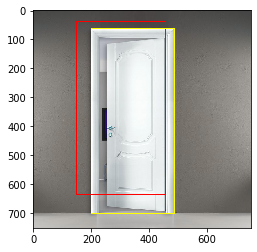

In [16]:
img_file_list = glob.glob( DATASET_PATH + "/*.jpg", recursive=True)
    
for img in img_file_list :
    name = Path(img).stem
    img_path = DATASET_PATH + name + ".jpg"
    annotation_path = DATASET_PATH + name + ".xml"

    print(img_path,annotation_path)
        
    out_img , detection_result = obj_detector.run_detection(img).get_result()
    annotation_result = read_annotation(annotation_path)
    
    print(detection_result)
    print(annotation_result)
    
    # IoU for "Door" 
    door_detection_bbox = get_bbox_for_label(detection_result,"Door")
    door_annotation_bbox = get_bbox_for_label(annotation_result,"door")
    
    door_single_IoU = bb_intersection_over_union(door_detection_bbox,door_annotation_bbox)
    print(door_single_IoU)
    
    out_img = cv2.imread(img_path)
    cv2.rectangle(out_img,(149, 40),(454, 635),(255,0,0),2)
    cv2.rectangle(out_img,(199, 64),(487, 699),(255,255,0),2)
    
    plt.imshow(out_img)
    plt.show()
    
    # IoU for "Handle"
    # handle_detection_bbox = get_bbox_for_label(detection_result,"Door handle")
    # handle_annotation_bbox = get_bbox_for_label(annotation_result,"Door handle")
    
    # handle_single_IoU = bb_intersection_over_union(handle_detection_bbox,handle_annotation_bbox)
    
    break

### References

1. https://tarangshah.com/blog/2018-01-27/what-is-map-understanding-the-statistic-of-choice-for-comparing-object-detection-models/
2. https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
3. http://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf
4. http://cocodataset.org/#detection-eval
5. https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python